## Investigate trimming

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

import functions_py.fates_xarray_functions as fa

In [2]:
pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

###  Load the fates  runs

In [3]:
fates = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/fbnc_f45_allom_CA_height_agb.Eb8be65d66e-Ffc130cb8.2023-10-11/run/fbnc_f45_allom_CA_height_agb.Eb8be65d66e-Ffc130cb8.2023-10-11.2080s.nc'
fates = xr.open_dataset(fates, decode_times=False)

time = fates.variables['time'] / 365.
cohort_size_bins = fates.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

In [4]:
### Functions
def decay_coeff_kn(vcmax25top):
    ans = np.exp(0.00963 * vcmax25top - 2.43)
    return ans


def clllpf_to_cn_lf_by_pft(clllpf_var, dataset, dataset2):
    """function to reshape a fates multiplexed canopy layer, leaf layer and pft-indexed variable to one indexed by canopy layer leaf layer and pft
    first argument should be an xarray DataArray that has the FATES CLLLPF dimension
    second argument should be an xarray Dataset that has the FATES CLLL dimensions
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the cnlf  (CLLL) and pft dimensions disentangled"""
    n_cnlf = len(dataset.fates_levcnlf)
    ds_out = (clllpf_var.rolling(fates_levcnlfpf=n_cnlf, center=False)
            .construct("fates_levcnlf")
            .isel(fates_levcnlfpf=slice(n_cnlf-1, None, n_cnlf))
            .rename({'fates_levcnlfpf':'fates_levpft'})
            .assign_coords({'fates_levcnlf':dataset.fates_levcnlf})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    ds_out.attrs['long_name'] = clllpf_var.attrs['long_name']
    ds_out.attrs['units'] = clllpf_var.attrs['units']
    
    # now create a new dimension - leaf layers - and disentangle canopy layers and leaf layers
    n_levleaf = len(dataset2.fates_levleaf)
    ds_out2 = (ds_out.rolling(fates_levcnlf=n_levleaf, center=False)
               .construct("fates_levleaf")
               .isel(fates_levcnlf=slice(n_levleaf-1, None, n_levleaf))
               .rename({'fates_levcnlf':'fates_levcan'})
               .assign_coords({'fates_levleaf':dataset2.fates_levleaf})
               .assign_coords({'fates_levcan':dataset.fates_levcan}))
    ds_out2.attrs['long_name'] = ds_out.attrs['long_name']
    ds_out2.attrs['units'] = ds_out.attrs['units']
    
    return(ds_out2)

In [5]:
# Leaf construction cost depends on cumulative LAI which corresponds to the leaf layer 
# dimension in CLLLPF. Therefore calculate leaf construction cost for each leaf layer and
# subtract from NET_C_UPTAKE_CLLLPF to get the full net C uptake. 

# PFT level parameters 
vcmax25top = [50, 62, 39, 61, 58, 58, 62, 54, 54, 78, 78, 78]
slatop = [0.018, 0.006, 0.0288, 0.0108, 0.036, 0.036, 0.0144, 0.036, 0.036, 0.036, 0.036, 0.03]
slamax = [ 0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.012, 0.03, 0.03, 0.03, 0.03, 0.03]
root_long = [2, 2, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1, 1]
leaf_long = [2.5, 4, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1, 1]
season_decid = [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]
stress_decid = [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]
grperc = [ 0.08, 0.11, 0.11, 0.11, 0.11, 0.08, 0.11, 0.11, 0.11, 0.11, 
    0.11, 0.11]
l2fr = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

vai_top_bin_width = 0.1
vai_width_increase_factor = 1.1
nlevleaf = 37 # it is actually 36 but do 37 here to get midpoints
z = np.linspace(1,nlevleaf,nlevleaf)
dinc_vai = vai_top_bin_width * vai_width_increase_factor ** z
cumulative_lais = np.cumsum(dinc_vai)

lower = cumulative_lais[0:-1]
upper = cumulative_lais[1:]
leaf_layer_mids = (lower + upper)*0.5

# make a dataset that has a fates_levleaf dimension
data = np.arange(36)
locs = leaf_layer_mids
dataset2 = xr.DataArray(data, coords={'fates_levleaf':locs}, dims = 'fates_levleaf')


In [6]:
leaf_costs = []

# This is kg C m-2 yr-1 (per unit ground area?)
for pf in range(len(pftnames)):
    
    pft_kn = decay_coeff_kn(vcmax25top[pf])
    nscaler_levleaf = np.exp(-pft_kn * leaf_layer_mids)  
    sla_levleaf = slatop[pf] / nscaler_levleaf
    m = [idx for idx in range(len(sla_levleaf)) if sla_levleaf[idx] > slamax[pf]]
    sla_levleaf[m] = slamax[pf]
    
    # if deciduous
    if(season_decid[pf] == 1) or (stress_decid[pf] == 1):
        # account for sla profile 
        leaf_cost = 1 / (sla_levleaf * 1000) 
        # growth respiration tax
        leaf_cost = (leaf_cost * (grperc[pf] + 1))
    
    # if evergreen    
    else : 
        leaf_cost = (1 / (sla_levleaf * 1000 * leaf_long[pf])) 
        leaf_cost = (leaf_cost * (grperc[pf] + 1)) 
    
    bfr_per_bleaf = l2fr[pf]
    leaf_cost = leaf_cost + ( 1 / (sla_levleaf * 1000) * bfr_per_bleaf / root_long[pf] )
    
    leaf_costs.append(leaf_cost)
    
    
leaf_costs = xr.DataArray(leaf_costs, dims = ['fates_levpft', 'fates_levleaf'], coords=[np.arange(len(l2fr))+1, leaf_layer_mids])    


In [7]:
# untangle all the dimensions  - this variable is in kg C m-2 s-1 (per ground area NOT leaf area)
ds5_raw = clllpf_to_cn_lf_by_pft(fates['FATES_NET_C_UPTAKE_CLLLPF'], fates, dataset2) 

# max area of each pft in no comp
pft_frac = fates.FATES_NOCOMP_PATCHAREA_PF  # in m2 m-2

# Subtract leaf costs from net C uptake ( make net C uptake annual)
ds5 = ds5_raw/pft_frac * (pft_frac/pft_frac) * 86400 * 365
ds6 = ds5 - leaf_costs

# Now in kg C m-2 yr-1

# average over time and remove empty canopy layers
# remove empty canopy layer
#ds7 = ds6.isel(fates_levcan=0)

# mean over time
ds8 = ds6.mean(dim='time')

print(ds8.shape)

(12, 46, 72, 2, 36)


In [8]:
ds8.dims

('fates_levpft', 'lat', 'lon', 'fates_levcan', 'fates_levleaf')

#### Net c uptake by leaf layer -  canopy layer 0, pft 1

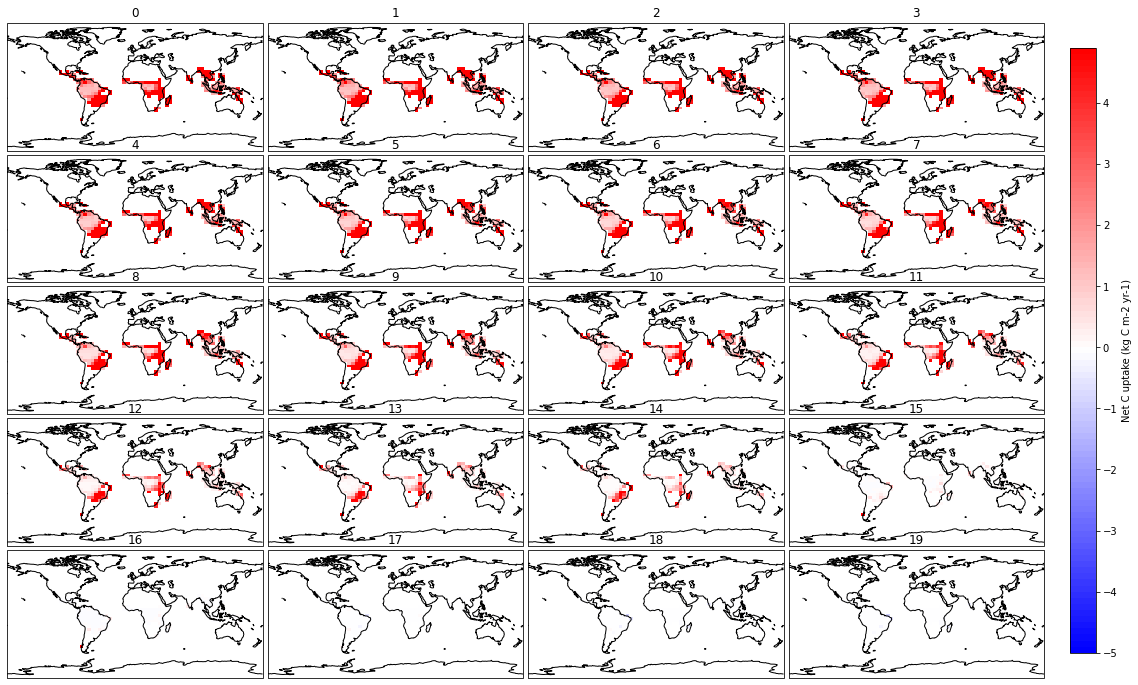

In [9]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(-5.,5.,0.1)
fig, axs = plt.subplots(nrows=5,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,14))

axs = axs.flatten()

for i in range(0,len(axs)):
    
    tmp = ds8.isel(fates_levpft=0).isel(fates_levcan=0).isel(fates_levleaf=i)
    cs = tmp.plot(levels=clevs,cmap='bwr', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(i)
            

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Net C uptake (kg C m-2 yr-1)')

#### Net c uptake by leaf layer -  canopy layer 1, pft 1

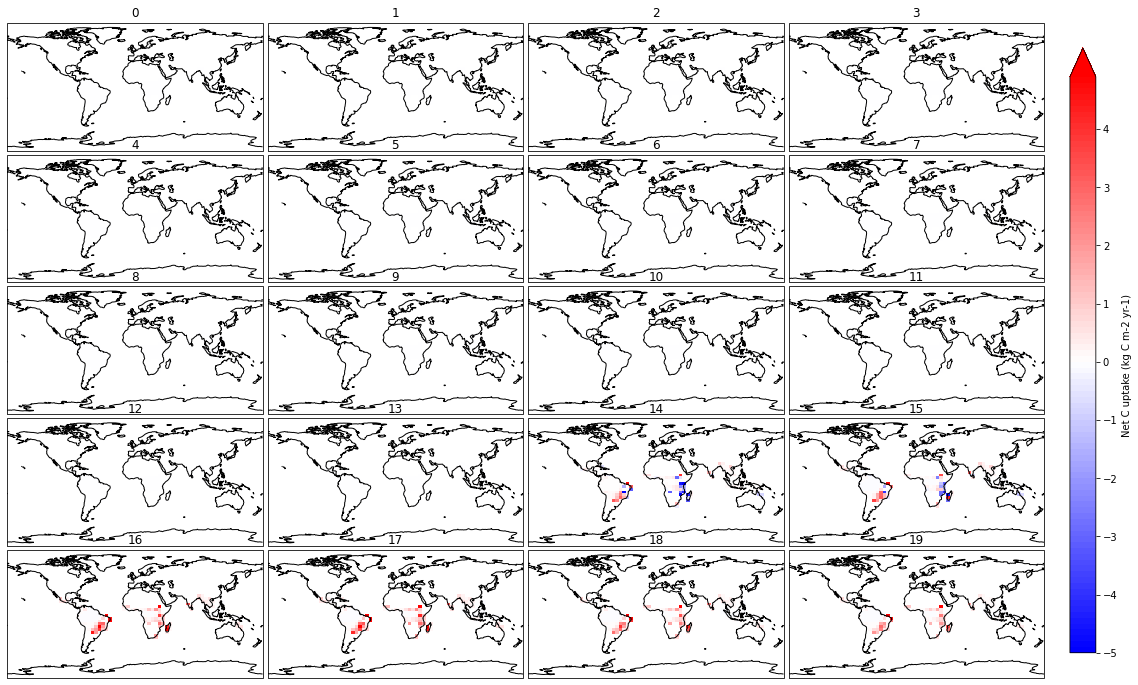

In [10]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(-5.,5.,0.1)
fig, axs = plt.subplots(nrows=5,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,14))

axs = axs.flatten()

for i in range(0,len(axs)):
    
    tmp = ds8.isel(fates_levpft=0).isel(fates_levcan=1).isel(fates_levleaf=i)
    cs = tmp.plot(levels=clevs,cmap='bwr', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(i)
            

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Net C uptake (kg C m-2 yr-1)')

#### PFT 2 

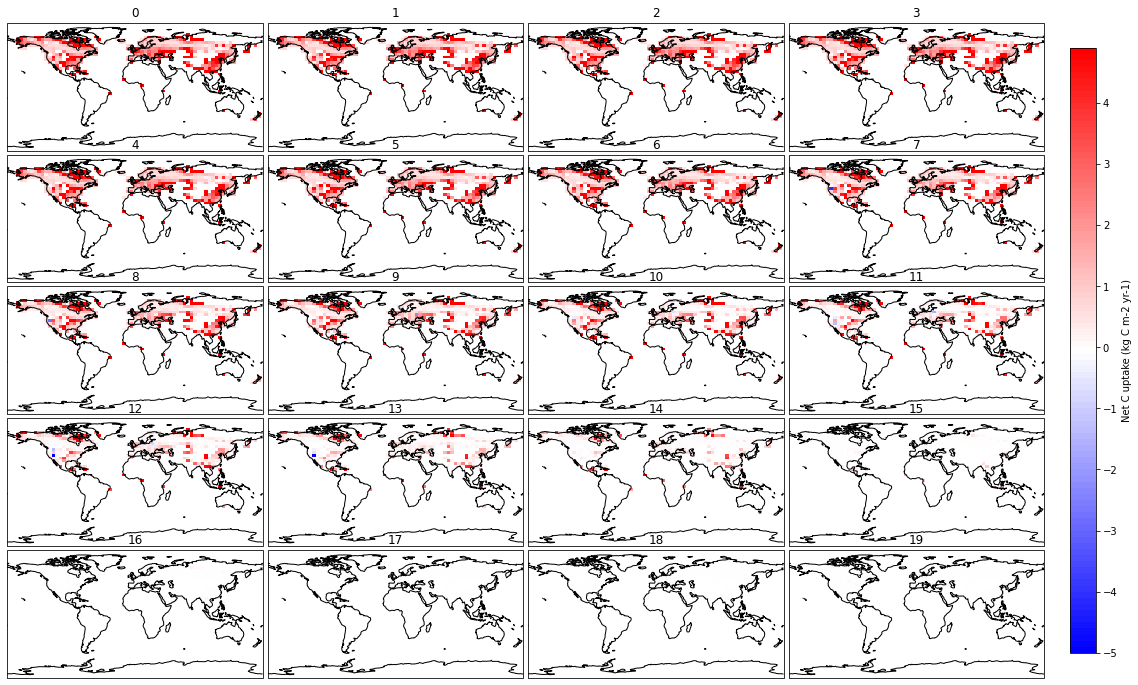

In [11]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(-5.,5.,0.1)
fig, axs = plt.subplots(nrows=5,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,14))

axs = axs.flatten()

for i in range(0,len(axs)):
    
    tmp = ds8.isel(fates_levpft=1).isel(fates_levcan=0).isel(fates_levleaf=i)
    cs = tmp.plot(levels=clevs,cmap='bwr', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(i)
            

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Net C uptake (kg C m-2 yr-1)')

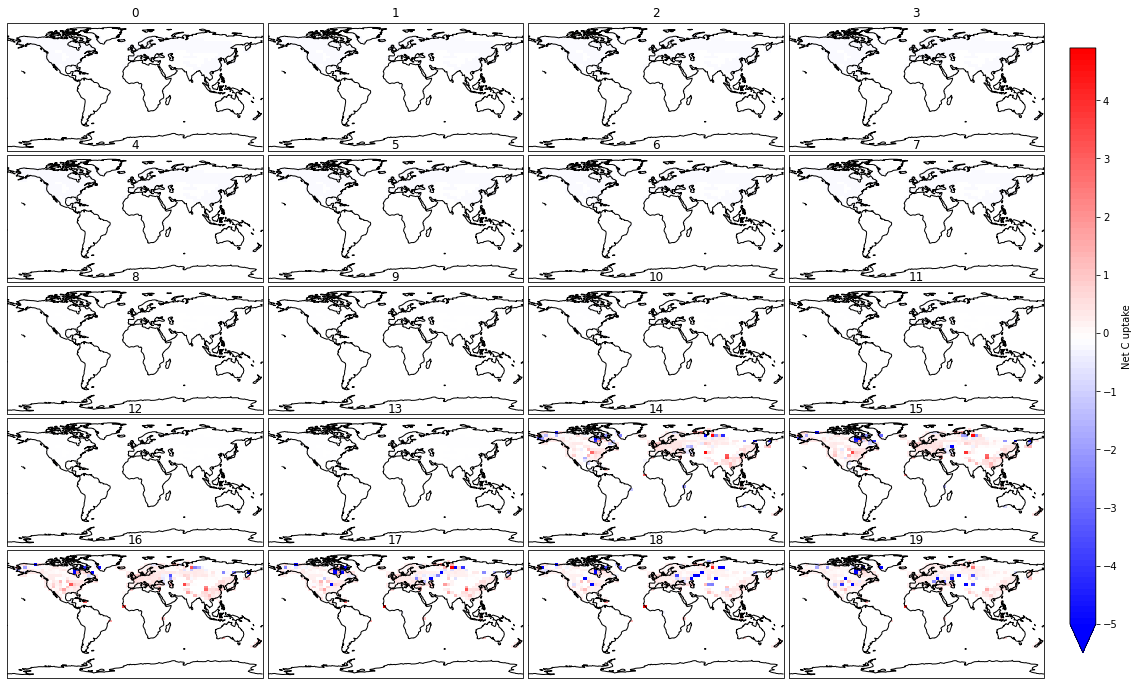

In [12]:
clevs=np.arange(-5.,5.,0.1)
fig, axs = plt.subplots(nrows=5,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,14))

axs = axs.flatten()

for i in range(0,len(axs)):
    
    tmp = ds8.isel(fates_levpft=1).isel(fates_levcan=1).isel(fates_levleaf=i)
    cs = tmp.plot(levels=clevs,cmap='bwr', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(i)
            

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Net C uptake')

#### Number of plants by PFT

In [15]:
nplant_pft = fates.FATES_NPLANT_PF * fates.FATES_FRACTION
nplant_pft = nplant_pft.mean(dim='time')
print(nplant_pft.shape)

(12, 46, 72)


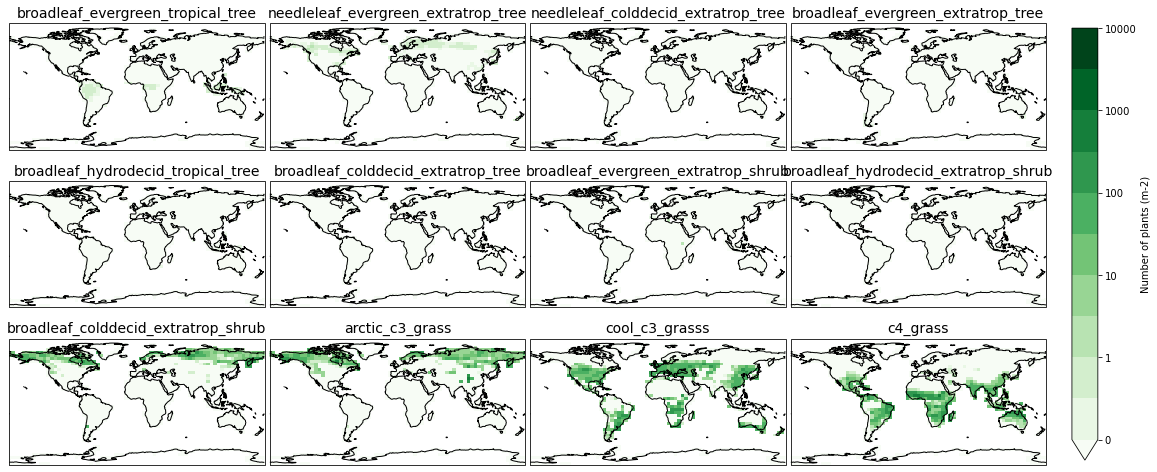

In [20]:
clevs=np.array([0.1,0.3,1.,3.,10.,30., 100.,300.,1000., 3000., 10000.])
fig, axs = plt.subplots(nrows=3,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10))

axs = axs.flatten()

for i in range(0,len(pftnames)):
    
    tmp = nplant_pft.isel(fates_levpft=i)
    cs = tmp.plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(pftnames[i], fontsize=14)
            

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Number of plants (m-2)')

### Canopy growth rates

In [21]:
nplant = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_SZPF, fates) 
nplant_c = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_CANOPY_SZPF, fates) 
nplant_u = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_USTORY_SZPF, fates) 

nplant = nplant  * fates.FATES_FRACTION
nplant = nplant.sum(dim='fates_levscls')
nplant_c = nplant_c * fates.FATES_FRACTION
nplant_c = nplant_c.sum(dim='fates_levscls')
nplant_u = nplant_u * fates.FATES_FRACTION
nplant_u = nplant_u.sum(dim='fates_levscls')

In [22]:
ddbh_canopy = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_CANOPY_SZPF, fates)
# multiply by fates fraction
ddbh_canopy = ddbh_canopy * fates.FATES_FRACTION
# sum over sizes
ddbh_canopy = ddbh_canopy.sum(dim='fates_levscls')
# divide by nplant
ddbh_canopy  = ddbh_canopy / nplant_c
# mean over time
ddbh_canopy = ddbh_canopy.mean(dim='time')
# convert to cm
ddbh_canopy = ddbh_canopy * 100

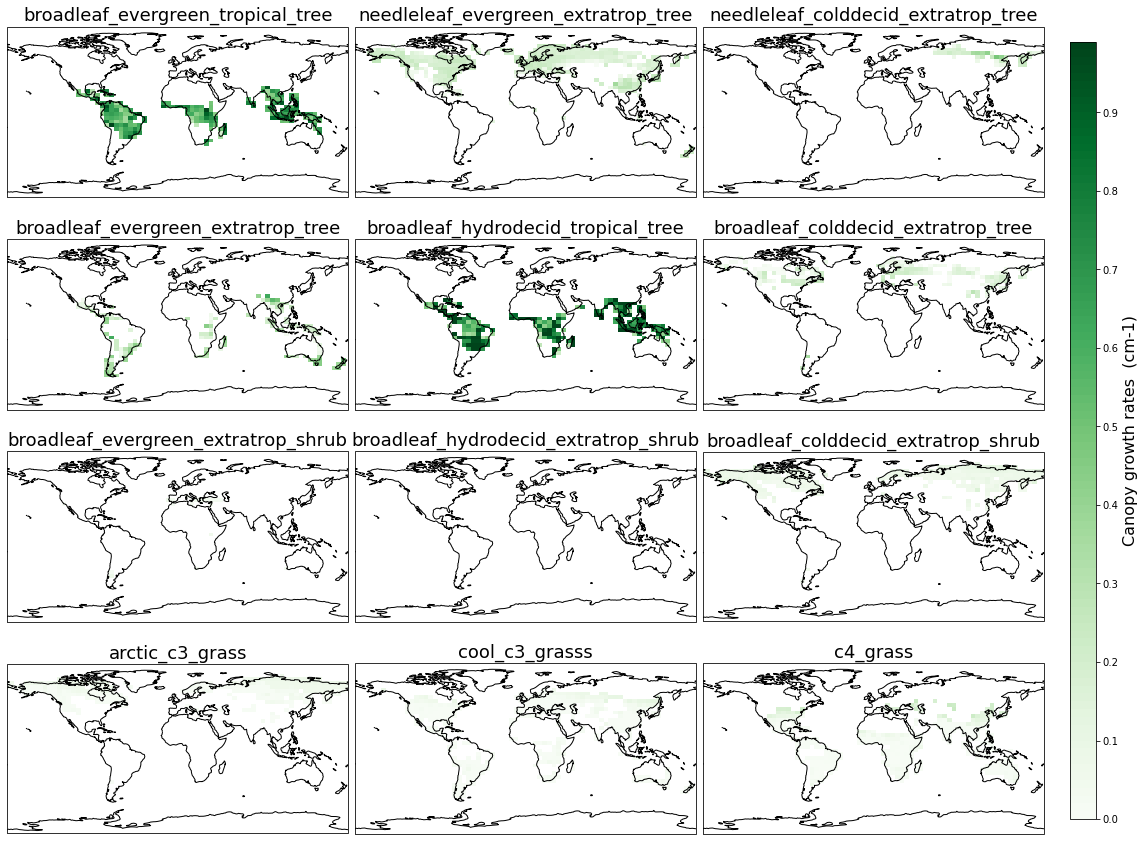

In [25]:
clevs=np.arange(0.,1.,0.01)
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,18))
axs = axs.flatten()

for i in range(0,12):
    cs= ddbh_canopy.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
    ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(pftnames[i], fontsize=18)
            
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Canopy growth rates  (cm-1)', fontsize=16)

In [26]:
ddbh_ustory = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_USTORY_SZPF, fates)
# multiply by fates fraction
ddbh_ustory = ddbh_ustory * fates.FATES_FRACTION
# sum over sizes
ddbh_ustory = ddbh_ustory.sum(dim='fates_levscls')
# divide by nplant
ddbh_ustory  = ddbh_ustory / nplant_c
# mean over time
ddbh_ustory = ddbh_ustory.mean(dim='time')
# convert to cm
ddbh_ustory = ddbh_ustory * 100

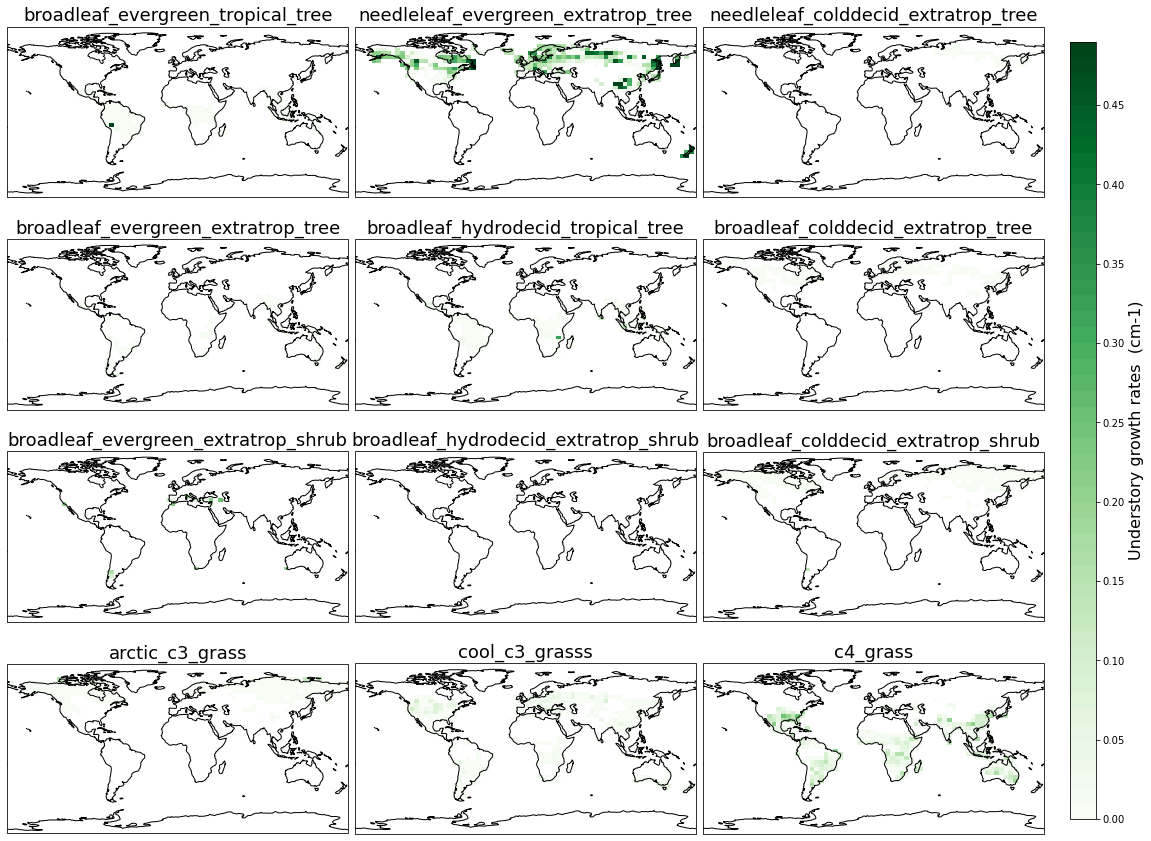

In [28]:
clevs=np.arange(0.,0.5,0.01)
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,18))
axs = axs.flatten()

for i in range(0,12):
    cs= ddbh_ustory.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
    ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(pftnames[i], fontsize=18)
            
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Understory growth rates  (cm-1)', fontsize=16)